# A Comprehensive Twitter US Airline Sentiment Analysis


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
#from plotnine import ggplot, aes, geom_line
#from PIL import Image

import re
import os
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from textblob.classifiers import NaiveBayesClassifier
import warnings
%matplotlib inline

In [26]:
# Set images size
plt.rcParams["figure.figsize"] = (11,8);

# Set column print size to 140 characters to make sure that the tweets are
# fully printed - back in 2015 only 140 chars were allowed
pd.options.display.max_colwidth = 140

# ignore depreciation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [23]:
df = pd.read_csv('../Datasets/Tweets.csv')
df.sample(4)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1383,569748501342478336,negative,1.0,Customer Service Issue,0.6522,United,NaN,BrentOya,NaN,0,"@united SF crew lack a lot of customer service, LAX employees are a lot better. Wonder why...",NaN,2015-02-22 22:40:02 -0800,NaN,NaN
8428,568380749495164929,neutral,1.0,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,"@JetBlue Gains Altitude, But SkyWest Hits Turbulence JBLU SKYW - Investor's Business Daily http://t.co/P2HUM7lXUR",NaN,2015-02-19 04:05:05 -0800,USA,Sydney
13516,569843745157451776,negative,1.0,Customer Service Issue,1.0000,American,NaN,EaglesJade,NaN,0,@AmericanAir stranded in Miami because your automated system keeps hanging up on me for two days. Help !,NaN,2015-02-23 04:58:30 -0800,NaN,NaN
2395,569231858485080066,negative,1.0,Late Flight,0.3556,United,NaN,WSlough,NaN,0,@united stuck in DC trying to get to Denver. The engine shut down twice on us at the terminal. Got any available flights for me?,"[38.94291482, -77.44870496]",2015-02-21 12:27:05 -0800,"Richmond, VA",NaN


## Clean Data

In [4]:
# Some quick infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [41]:
# Let's print some of the tweets:
df['text'].head(10)

0                                                                                                         @VirginAmerica What @dhepburn said.
1                                                                    @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                     @VirginAmerica I didn't today... Must mean I need to take another trip!
3              @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                     @VirginAmerica and it's a really big bad thing about it
5    @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6                                                             @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
7     

To clean the tweets we get rid of:

1. Handles -airlines have a dedicated column-
2. Punctuations, numbers and special characters
3. less than 4 chars words


In [78]:
# 1. & 2.
df['tweet_clean'] = df['text'].apply(lambda x: re.sub(r"@\S+|https?://\S+|[^a-zA-Z#\s]", '', x ).strip())

In [79]:
df['tweet_clean'].head(10)

0                                                                                                             What  said
1                                                                   plus youve added commercials to the experience tacky
2                                                                    I didnt today Must mean I need to take another trip
3              its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
4                                                                                and its a really big bad thing about it
5    seriously would pay  a flight for seats that didnt have this playing\nits really the only bad thing about flying VA
6                                                              yes nearly every time I fly VX this ear worm wont go away
7                                                    Really missed a prime opportunity for Men Without Hats parody there
8                               

In [80]:
# Remove short words
df['tweet_clean'] = df['tweet_clean'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
df[['text', 'tweet_clean']].head(10)

,text,tweet_clean
0,@VirginAmerica What @dhepburn said.,What said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,plus youve added commercials the experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,didnt today Must mean need take another trip
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",its really aggressive blast obnoxious entertainment your guests faces amp they have little recourse
4,@VirginAmerica and it's a really big bad thing about it,and its really big bad thing about
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,seriously would pay flight for seats that didnt have this playing its really the only bad thing about flying
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",yes nearly every time fly this ear worm wont away
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",Really missed prime opportunity for Men Without Hats parody there
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",Well didntbut NOW
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",was amazing and arrived hour early Youre too good


## Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Summary of Global Sentiment')

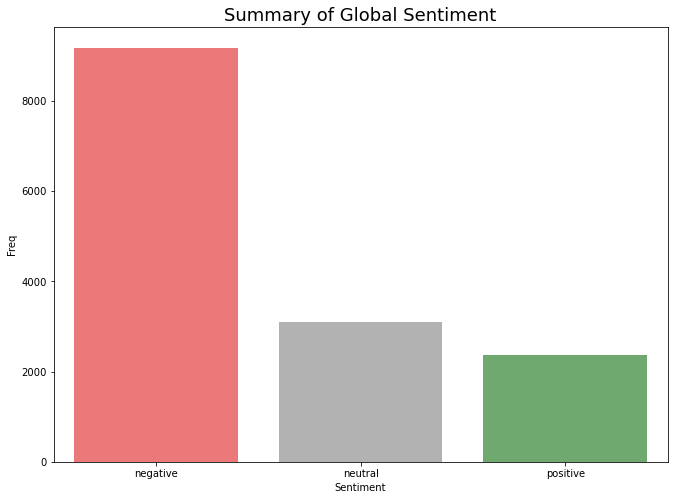

In [81]:
# summary of global sentiment
sns.set_palette("pastel")
sns.countplot(x=df['airline_sentiment'].sort_values() , 
              alpha=.6, 
              palette={'negative':'r', 
                       'neutral': 'grey', 
                       'positive': 'green'})
plt.ylabel('Freq')
plt.xlabel('Sentiment')
plt.title('Summary of Global Sentiment', fontsize=18)

In [82]:
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [83]:
# Tweets per airline in percent
tweets_per_airline = (df[['airline', 'text']].groupby('airline').count()/len(df['text'].notna().notnull())).sort_values(by='text', ascending=False)
tweets_per_airline

,text
airline,
United,0.261066
US Airways,0.198975
American,0.188456
Southwest,0.165301
Delta,0.151776
Virgin America,0.034426


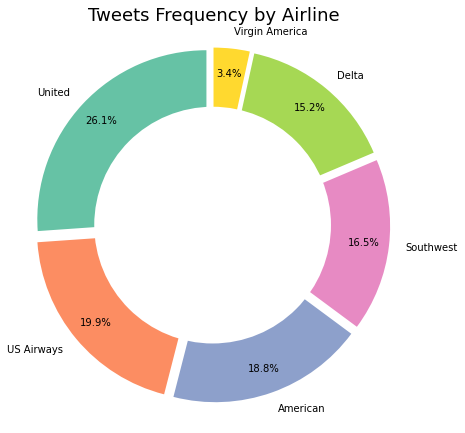

In [84]:
 
# Pie Chart of normalized tweets frequency for each airline
# Although, it is not recommended to use pie chart as visualization, 
# since they could be confusing and hard to understand, it doesn't hurt
# to learn how to do it

#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#33ccff', '#ff6600']
colors = sns.color_palette('Set2',10)
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
plt.pie(tweets_per_airline.text, labels=tweets_per_airline.index.values, autopct='%1.1f%%', 
startangle=90, colors=colors,
pctdistance=0.85, explode = [0.05]*tweets_per_airline.shape[0])
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
ax1.axis('equal')  
plt.tight_layout()
plt.title('Tweets Frequency by Airline', fontsize=18,);

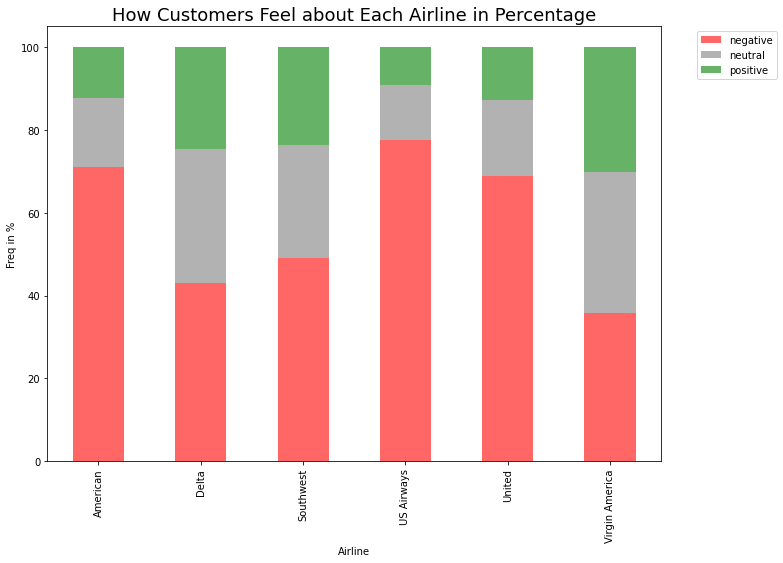

In [85]:
# Plot sentiment rates per airline
_ = pd.crosstab(df.airline, df.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',
                title='How Customers Feel about Each Airline in Percentage', 
                stacked=True,
                color=['red', 'grey', 'green'], alpha=0.6 )

_.title.set_size(18)
_.set_xlabel('Airline')
_.set_ylabel('Freq in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

From the above figure we can already see that Virgin America has the best customer sentiment and US Airways the worst. Indeed, Virgin America was ranked as the second best US airline in the US in 2015 [[1]](https://www.airfarewatchdog.com/blog/23248943/best-u-s-airlines-2015-edition/), while US Airways the 8th or the second worst before United. However, it is important to put those numbers in relation to the total number of customers per carrier for the year 2015. Because what appears to be a large number can, once put into proportion, become really small. So we need to be careful about this kind of  conclusions. 
Nonetheless, knowing that Virgin America was ranked second best in the US in 2015 and best between 2012 and 2014 is a good starting point to understand, from the customer point of view, what makes it better than the rest depicted above.

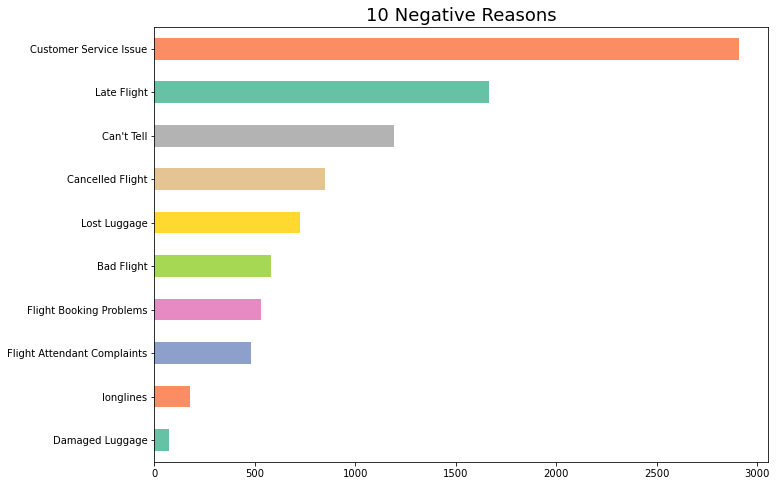

In [86]:
# Let's investigate more  the negative customer sentiments
colors = sns.color_palette('Set2',df['negativereason'].nunique())
df['negativereason'].value_counts().sort_values().plot(kind='barh', color=colors)
plt.title('10 Negative Reasons', fontsize=18,);

There are 10 different reasons for negative reviews. The most important ones are:

1. Customer Service Issue with almost 3000 tweets
2. Late flight (Nr of tweets= 1665)
3. Can't tell, which means the overall flight experience with more than 1100 tweets.

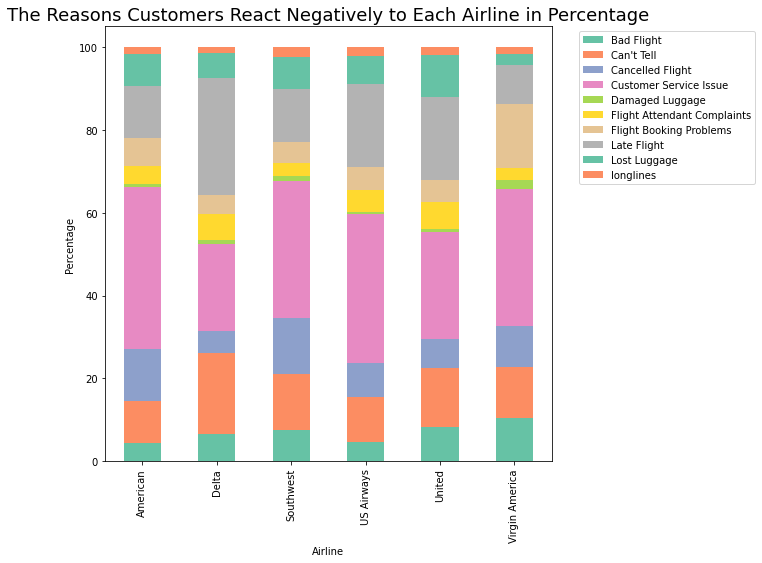

In [87]:
# Visualize negative reasons in percentage per airline
pd.crosstab(df.airline, df.negativereason).apply(lambda x: x/x.sum() * 100, axis=1).plot(kind="bar",color = colors,figsize=(8,8),stacked=True)
plt.title('The Reasons Customers React Negatively to Each Airline in Percentage', fontsize=18)
plt.xlabel('Airline')
plt.ylabel('Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

Showing this kind of graph is all well and good, but it is important to connect each of these sources of negative reactions to the value chain of the company in question in order to determine the actions that need to be taken to increase customer satisfaction. 
After all, this kind of analysis only makes sense if it leads to effective actions.

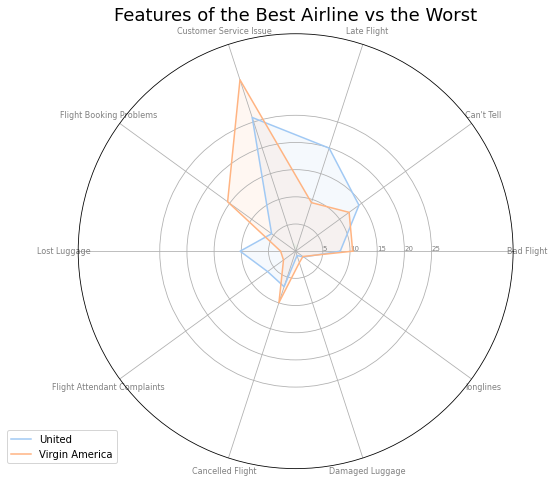

In [88]:
# Plot a radar chart with the negative reasons for three carriers
# Generate a dataframe with negative reasons rates per carrier for 3 carriers
neg_rev = pd.DataFrame(index=df['negativereason'].dropna().unique())
for air in ['United', 'Virgin America']:
    neg_rev[air] = df[df['airline'] == air]['negativereason'].value_counts(normalize=True)*100

# number of variable
categories = list(neg_rev.index)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# We are going to plot the first column of the data frame.
# But we need to repeat the first value to close the circular graph:
values = neg_rev.values
values = np.append(values, [values[0,:]], axis=0)
labels = neg_rev.columns.values


# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25], ["5","10","15",'20','25'], color="grey", size=7)
plt.ylim(0,40)
# Plot data
for y_arr, label in zip(values.T, labels):
    ax.plot(angles, y_arr, linewidth=1.5, linestyle='solid', label=label)
# Fill area
ax.fill(angles, values, ['b', 'o', 'green'], alpha=0.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),)

plt.title('Features of the Best Airline vs the Worst', fontsize=18,);
# Show the graph
plt.show()

It seems that travelers give much more importance to flight delays and lost luggages than to technical problems during online ticket booking.So to compete with best airline companies havee to improve thooses both variable.

Let's compare virgin america with delta, which is ranked as the third best and comes exactly after virgin for overall performance 


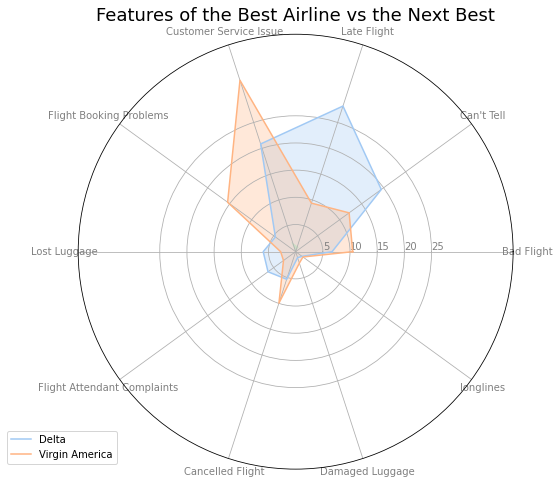

In [89]:
# Plot a radar chart with the negative reasons for three carriers
# Generate a dataframe with negative reasons rates per carrier for 3 carriers
neg_rev = pd.DataFrame(index=df['negativereason'].dropna().unique())
for air in ['Delta', 'Virgin America']:
    neg_rev[air] = df[df['airline'] == air]['negativereason'].value_counts(normalize=True)*100

# number of variable
categories = list(neg_rev.index)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# We are going to plot the first column of the data frame.
# But we need to repeat the first value to close the circular graph:
values = neg_rev.values
values = np.append(values, [values[0,:]], axis=0)
labels = neg_rev.columns.values


# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=10)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25], ["5","10","15",'20','25'], color="grey", size=10)
plt.ylim(0,40)
# Plot data
for y_arr, label in zip(values.T, labels):
    ax.plot(angles, y_arr, linewidth=1.5, linestyle='solid', label=label)
# Fill area
ax.fill(angles, values, ['b', 'o', 'green'], alpha=0.3)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),)

plt.title('Features of the Best Airline vs the Next Best', fontsize=18,);
# Show the graph
plt.show()

In [90]:
# Generate a word cloud for negative tweets
tweets = df[df['airline_sentiment']=='negative']

In [96]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=400,
                      height=250,
                      min_font_size=6,
                      collocation_threshold=120,
                      max_words=100,
                     ).generate(words_cleaned)

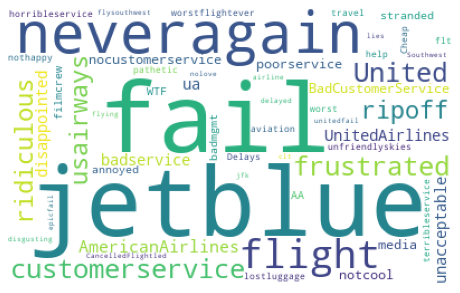

In [97]:
plt.figure(1,figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()